# Loss Function Experiments


## Setup


In [2]:
%load_ext autoreload

import numpy as np
import math
import random
import os
import os.path
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

from tqdm.notebook import tqdm
from ipywidgets import interact 
import gc
import open3d as o3d

from src.elements import *
from src.ifc import *
from src.preparation import *
from src.visualisation import *
from src.chamfer import *
from src.utils import *

from src.morph import *

random.seed = 42
rng = default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook contains experiments on loss functions.

Specifically it contains;

1. Analysis of results from sphere morphing, including consistency metrics
2. Visualising point-wise distances from a loss function
3. Measuring loss correlation in results from completion models

#### data loading and pre-processing

All data from sphere morphing must be loaded for analysis.


In [ ]:
# helper code to recombine batched output from balancedCD
file_prefix = "sphere/balanced_metrics"
icd_chamfer_list, icd_emd_list, icd_assignment_list = [], [], []

for i in range(1,9):
    with open(file_prefix + str(i) + ".pkl", "rb") as f:
        chamfer, emd, ass = pickle.load(f)
        print(len(ass), len(ass[0]), len(ass[0][0]), ass[0][0][0].shape)
        icd_chamfer_list.append(chamfer)
        icd_emd_list.append(emd)
        icd_assignment_list.append(ass[0])

icd_assignment_list = np.array(icd_assignment_list)        
icd_assignment_list = np.transpose(icd_assignment_list, axes=(1,2,0,3,4))
icd_assignment_list = np.reshape(icd_assignment_list, (101, 2, 8*150, 4096))

In [ ]:
balanced_cd = np.sum(np.array(icd_chamfer_list), axis=0)
balanced_emd = np.sum(np.array(icd_emd_list), axis=0)
print(balanced_emd.shape)

In [ ]:
# load metrics
loss_funcs = ["emd"]
#loss_funcs = ["infocd", "chamfer", "emd", "balanced"]
chamfer_list, emd_list = [], []
for loss_func in loss_funcs:
    if loss_func == "balanced":
        continue
    with open("sphere/" + loss_func + "_metrics.pkl", "rb") as f:
        chamfer, emd, ass = pickle.load(f)
        chamfer_list.append(chamfer)
        emd_list.append(emd)


In [ ]:
if "balanced" in loss_funcs:
    chamfer_list.append(balanced_cd)
    emd_list.append(balanced_emd)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
loss_funcs = ["infoCD", "CD", "EMD", "UniformCD"]

plot_dists(axes[1], chamfer_list, loss_funcs, "Chamfer Distance", "iterations", log=True)
plot_dists(axes[0], emd_list, loss_funcs, "Earth Mover's Distance", "iterations", log=True)
print("EMD infocd", emd_list[0][-1], "chamfer", emd_list[1][-1],  "emd", emd_list[2][-1], "BALANCED", emd_list[3][-1])
print("CD infocd", chamfer_list[0][-1], "chamfer", chamfer_list[1][-1], "emd", chamfer_list[2][-1], "balanced", chamfer_list[3][-1])


In [ ]:
print(len(ass), len(ass[0]), ass[0][0].shape, len(ass[0][0]), ass[0][0][0].shape)
print(emd_list[1][0])

In [ ]:
# load losses
# single, not batch
loss_types = ["reverse", "chamfer", "emd", "pair"]
losses = []

for loss_func in loss_types:
    with open("sphere/loss_" + loss_func + ".pkl", "rb") as f:
        losses.append(pickle.load(f))
        
plot_dists(losses, loss_types, "loss function comparison")


#### consistency metrics

We measure;

1. backward assignment consistency
2. coorrespondence coverage
3. correspondence stability


In [ ]:
# measure conssistency between forward and backward correspondences for chamfer distance
# optionally compare against the ideal assignment, as measured by EMD
# def measure_assignment_consistency(assignment, emd=None):
#     reverse_assignment = torch.gather(assignment[0], 0, assignment[1])
#     expected = torch.arange(assignment[0].shape[0], device=torch.device("cuda"))
#     consistency = torch.sum(torch.eq(expected, reverse_assignment).long())
#     print("consistency", consistency.item(), len(torch.unique(assignment[0])), len(torch.unique(assignment[1])))
    
#     if emd is not None:
#         #print(emd[:5], assignment[0][:5], assignment[1][:5])
#         emd_consistency = torch.sum(torch.eq(emd, assignment[0]).long())
#         #print("emd_consistency", emd_consistency.item(), len(torch.unique(emd)))


In [ ]:
# measure conssistency for EMD approx correspondences
# this is different from other distances as only a one way assignment is returned
def measure_batch_assignment_consistency_emd(assignment):
    consistencies = np.array([4096 for i in range(assignment.shape[-1])])
    cuda = torch.device("cuda")

    uniques = []
    changes = []
    for i in tqdm(range(len(assignment))):
        class_assignment = torch.tensor(assignment[i], device=cuda)
        
        unique = 0
        for j in range(len(class_assignment)):
            unique += len(torch.unique(class_assignment[j]))
        unique = (unique/len(class_assignment))
        uniques.append(unique)
        
        # check rate of change of matches
        if i==0:
            change = 0
        else:
            change = (assignment[i] == assignment[i-1]).sum()
            change = (change/len(class_assignment[0]))
        changes.append(change)
        
        print("un", unique, "change", change)
        
    # save results
    with open("sphere/" + "emd" + "_consistency.pkl", "wb") as f:
        pickle.dump([consistencies, uniques, changes], f)

In [ ]:
measure_batch_assignment_consistency_emd(ass)

In [ ]:
# measure consistency between forward and backward correspondences
# measure number of unique assignments
# measure rate of change of assignments
def measure_batch_assignment_consistency(assignment, loss):
    cuda = torch.device("cuda")
    # loop through iterations
    consistencies = []
    uniques = []
    changes = []
    for i in tqdm(range(len(assignment))):
        
        # check reverse consistency
        class_assignment = torch.tensor(assignment[i], device=cuda)
        reverse_assignment = torch.gather(class_assignment[0], 1, class_assignment[1])
        #print("r", reverse_assignment.shape)
        expected = torch.arange(class_assignment[0].shape[1], device=cuda)
        expected = expected.repeat(class_assignment[0].shape[0], 1)
        #print("e", expected.shape)
        consistency = torch.sum(torch.eq(expected, reverse_assignment).long())/len(class_assignment[0])
        consistencies.append(consistency.item())
        
        # check uniqueness of matches
        unique = 0
        for j in range(len(class_assignment[0])):
            unique += (len(torch.unique(class_assignment[0][j])) +
                       len(torch.unique(class_assignment[1][j])))
        unique = (unique/len(class_assignment[0]))/2
        uniques.append(unique)
        
        # check rate of change of matches
        if i==0:
            change = 0
        else:
            change = (assignment[i] == assignment[i-1]).sum()
            change = (change/len(class_assignment[0]))/2
        changes.append(change)
        
        print("un", unique, "consistency", consistency.item(), "change", change)

    
    # save results
    with open("sphere/" + loss + "_consistency.pkl", "wb") as f:
        pickle.dump([consistencies, uniques, changes], f)


In [ ]:
# preprocess
loss = "emd"
#ass = np.array(ass)

if loss == "infocd":
    ass = np.transpose(ass, axes=(1,2,0,3,4,5))
    ass = np.reshape(ass, (101, 2, 8*150, 4096))
    
if loss == "chamfer":
    ass = np.transpose(ass, axes=(1,2,0,3,4))
    ass = np.reshape(ass, (101, 2, 8*150, 4096))
    
if loss == "emd":
    ass = np.array(ass)
    ass = np.transpose(ass, axes=(1,0,2,3))
    ass = np.reshape(ass, (101, 8*150, 4096))
print(ass.shape)

In [ ]:
measure_batch_assignment_consistency(icd_assignment_list, loss="UniformCD")
#measure_batch_assignment_consistency(ass, loss=loss)


In [ ]:
# plot consistency metrics

loss_funcs = ["infocd", "chamfer", "emd", "UniformCD"]
unique_list, consistency_list, change_list = [], [], []
for loss_func in loss_funcs:
    with open("sphere/" + loss_func + "_consistency.pkl", "rb") as f:
        consistency, unique, change = pickle.load(f)
        consistency_list.append(consistency)
        unique_list.append(unique)
        change_list.append(change)
print(change_list[0][-1], change_list[1][-1])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

limit= 50
loss_funcs = ["InfoCD", "CD", "EMD", "UniformCD"]

plot_dists(axes[0], consistency_list, loss_funcs, title="Backward consistency", 
           ylabel="no. of points", xlabel="Iterations", log=False, limit=limit, legend=False)
plot_dists(axes[1], unique_list, loss_funcs, title="Point coverage", 
           ylabel="", xlabel="Iterations", log=False, limit=limit, legend=False)
plot_dists(axes[2], change_list, loss_funcs, title="Correspondence variation", 
           ylabel="", xlabel="Iterations", log=False, limit=limit)


In [ ]:
# compare correspondences
#TODO: include consistency in top5 matches?
loss_func = "emd"
with open("sphere/assignments_" + "emd" + ".pkl", "rb") as f:
    emd_assignment = pickle.load(f)

with open("sphere/assignments_" + loss_func + ".pkl", "rb") as f:
    assignment = pickle.load(f)
    
for i, ass in enumerate(assignment):
    #measure_assignment_consistency(ass, emd_assignment[i][0])
    measure_assignment_consistency(ass)


#### Point-wise correspondence distance visualisation


In [ ]:
# load clouds
tgt_path = "sphere/target.pcd"
l1_path = "sphere/l1d.pcd"
l2_path = "sphere/l2d.pcd"
l3_path = "sphere/l3d.pcd"
l4_path = "sphere/l4d.pcd"

tgt = np.array(o3d.io.read_point_cloud(tgt_path).points)
l1 = np.array(o3d.io.read_point_cloud(l1_path).points)
l2 = np.array(o3d.io.read_point_cloud(l2_path).points)
l3 = np.array(o3d.io.read_point_cloud(l3_path).points)
l4 = np.array(o3d.io.read_point_cloud(l4_path).points)


In [ ]:
# measure point-wise distance between two clouds
def get_point_distance(src, tgt, loss="chamfer"):
    cuda = torch.device("cuda")
    src_tensor = torch.tensor([src], device=cuda)
    tgt_tensor = torch.tensor([tgt], device=cuda)
    chamferDist = ChamferDistance()

    if loss == "chamfer":
        nn = chamferDist(
            src_tensor, tgt_tensor, bidirectional=True, return_nn=True)
        weights = nn[1].dists[0,:,0]
        #print( torch.sum(nn[1].dists))
        loss = torch.sum(nn[1].dists)
        
    elif loss == "balanced":
        dist_0, dist_1 = calc_balanced_chamfer_loss_tensor(src_tensor, tgt_tensor, return_dists=True, k=32)
        loss = torch.sum(dist_1[0])
        #print( torch.sum(dist_1[0]))
        weights = dist_1[0]
    
    return weights.detach().cpu().numpy(), loss.item()


In [ ]:
# produce a colour map based on the weights of a point cloud
def visualise_point_loss(weights, high, low, colormap_name='plasma'):
    # normalise weights
    diff = high - low
    weights = (weights - low) / diff
    
    # map colour
    colours = np.zeros((len(weights), 4))
    colormap = plt.get_cmap(colormap_name)
    for j, pt in enumerate(weights):
        colours[j] = colormap(pt)

    return colours[:,:3]

In [ ]:
%autoreload 2

def get_point_weights(tgt, l1, l2, l3, l4, loss_func="chamfer"):
    w1, loss1 = get_point_distance(tgt, l1, loss_func)
    w2, loss2 = get_point_distance(tgt, l2, loss_func)
    w3, loss3 = get_point_distance(tgt, l3, loss_func)
    w4, loss4 = get_point_distance(tgt, l4, loss_func)

    high1, low1 = np.max(w1), np.min(w1)
    high2, low2 = np.max(w2), np.min(w2)
    high3, low3 = np.max(w3), np.min(w3)
    high4, low4 = np.max(w4), np.min(w4)

    high = max(high1, high2, high3, high4)
    low = min(low1, low2, low3, low4)
    
    losses = [loss1, loss2, loss3, loss4]
    print("loss1", loss1, "loss2", loss2, "loss3", loss3, "loss4", loss4)
    
    return high, low, w1, w2, w3, w4, losses


cd_high, cd_low, cd_w1, cd_w2, cd_w3, cd_w4, cd_losses = get_point_weights(tgt, l1, l2, l3, l4, loss_func="chamfer")
balanced_high, balanced_low, balanced_w1, balanced_w2, balanced_w3, balanced_w4, balanced_losses = get_point_weights(tgt, l1, l2, l3, l4, loss_func="balanced")

high, low = max(cd_high, balanced_high), min(cd_low, balanced_low)

#colours = visualise_point_loss(balanced_w1, high, low, 'plasma_r')
#colours = visualise_point_loss(balanced_w4, balanced_high, balanced_low, 'plasma_r')
colours = visualise_point_loss(cd_w2, cd_high, cd_low, 'plasma_r')

point_cloud = o3d.geometry.PointCloud()
#print(colours, cloud.shape)
point_cloud.points = o3d.utility.Vector3dVector(l2)
point_cloud.colors = o3d.utility.Vector3dVector(colours)
o3d.visualization.draw_geometries([point_cloud])

In [ ]:
point_cloud = o3d.geometry.PointCloud()
#print(colours, cloud.shape)
point_cloud.points = o3d.utility.Vector3dVector(tgt)
point_cloud.paint_uniform_color([0.1, 0.8, 0.6])

o3d.visualization.draw_geometries([point_cloud])

In [ ]:

print(normalize([balanced_losses]))
X = np.arange(4)

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
#ax.bar(X + 0.00, normalize([balanced_losses])[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, normalize([cd_losses])[0], color = 'mediumslateblue', width = 0.8)
ax.set(ylabel="Loss (normalised)")
ax.set(title="Chamfer distance")

x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,0.7))
ax.set_xticks([])

In [ ]:
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=10) 
#ax.bar(X + 0.00, normalize([balanced_losses])[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, normalize([balanced_losses])[0], color = 'indianred', width = 0.8)
ax.set(ylabel="Loss (normalised)")
ax.set(title="UniformCD distance")
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,0.7))
ax.set_xticks([])

#### CD EMD scatterplot


In [3]:
# on PCN results
with open ("sphere/out_metrics_cd.pkl", "rb") as f:
    chamfer_cd, chamfer_emd = pickle.load(f)
    
chamfer_cd = np.array(chamfer_cd)
chamfer_emd = np.array(chamfer_emd)*100

with open ("sphere/out_metrics.pkl", "rb") as f:
    balanced_cd, balanced_emd = pickle.load(f)
    
balanced_cd = np.array(balanced_cd)
balanced_emd = np.array(balanced_emd)*100


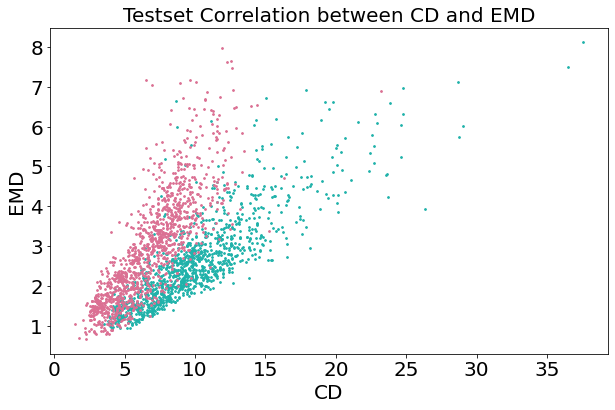

In [4]:

plt.rcParams['figure.figsize']=(10,6)
plt.xlabel('CD', fontsize=20)
plt.ylabel('EMD', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Testset Correlation between CD and EMD', fontsize=20)

plt.scatter(balanced_cd, balanced_emd, s=3, color="lightseagreen")
plt.scatter(chamfer_cd, chamfer_emd, s=3, color="palevioletred")


plt.show()

In [5]:
# find correlation between chamfer and EMD
import numpy as np
import scipy.stats

print("balanced r", scipy.stats.pearsonr(balanced_cd, balanced_emd))
print("chamfer r", scipy.stats.pearsonr(chamfer_cd, chamfer_emd))


balanced r PearsonRResult(statistic=0.8433735193336565, pvalue=0.0)
chamfer r PearsonRResult(statistic=0.8167748779166906, pvalue=1.994038304915139e-288)
